In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import qiskit
from qiskit import *
from math import pi
from qiskit.test.mock import FakeLondon
from qiskit import Aer
from qiskit import aqua
from NoiseModel import generateDepolarizingError, generateRelaxationError, generateNoiseModel
from qiskit.visualization import plot_histogram
import math
import cmath

t=1
U=1
machine = FakeLondon()
simulator = Aer.get_backend('qasm_simulator')
noise_model = generateNoiseModel(machine, coherent = False, incoherent = False, readout= False)

In [3]:
IBMQ.save_account(token="4d27cf4fc846df164ebc35734c48c5c21c3e3d8698af0b25c0a105dd651cd6245349d7f232c3b20c43f3650e0a8c87dcc098e76fcd31c182c0778441d4d975fd", hub="ibm-q-education", group="rutgers-2", project="vqe-research", overwrite=True)
IBMQ.load_account()
provider=IBMQ.get_provider("ibm-q-education")

In [4]:
#dummy parameters
phi = pi/4
theta = pi/4

# Circuit

Lets make a function out of this which takes in a value for gamma and outputs the circuit with gamma = that value

In [5]:
def get_hopping_circ(phi, theta):
    
    qreg_q = QuantumRegister(4, 'q')
    creg_c = ClassicalRegister(4, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    # Initialization
    circuit.ry(-pi/2, qreg_q[0])
    circuit.ry(-pi/2, qreg_q[1])
    
    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

    # Ansatz
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.rz(phi, qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.rx(theta, qreg_q[0])
    circuit.rx(theta, qreg_q[1])


    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

    # Diagonalization
    circuit.h(qreg_q[0])
    circuit.h(qreg_q[1])
    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
    
    circuit.cx(qreg_q[0], qreg_q[2])
    circuit.cx(qreg_q[1], qreg_q[3])
    circuit.x(qreg_q[2])
    circuit.x(qreg_q[3])
    # Measurement
    circuit.measure(qreg_q[0], creg_c[0])
    circuit.measure(qreg_q[1], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[2])
    circuit.measure(qreg_q[3], creg_c[3])
    
    return circuit

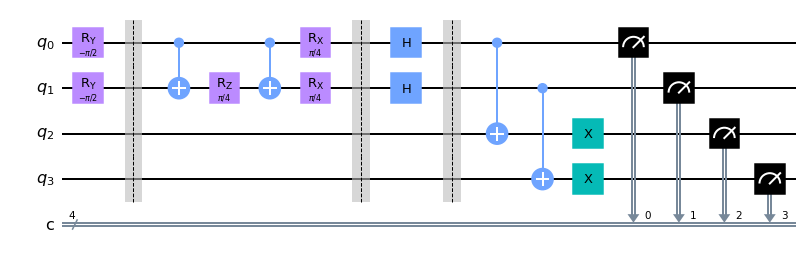

In [6]:
get_hopping_circ(phi, theta).draw('mpl')

In [7]:
def get_onsite_circ(phi, theta):
    
    qreg_q = QuantumRegister(4, 'q')
    creg_c = ClassicalRegister(4, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    # Initialization
    circuit.ry(-pi/2, qreg_q[0])
    circuit.ry(-pi/2, qreg_q[1])
    
    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

    # Ansatz
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.rz(phi, qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.rx(theta, qreg_q[0])
    circuit.rx(theta, qreg_q[1])

    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
    
    circuit.cx(qreg_q[0], qreg_q[2])
    circuit.cx(qreg_q[1], qreg_q[3])
    circuit.x(qreg_q[2])
    circuit.x(qreg_q[3])
    # Measurement
    circuit.measure(qreg_q[0], creg_c[0])
    circuit.measure(qreg_q[1], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[2])
    circuit.measure(qreg_q[3], creg_c[3])
    
    return circuit

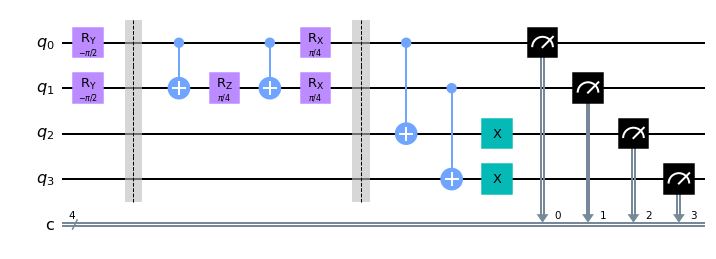

In [8]:
get_onsite_circ(phi, theta).draw('mpl')

# Measuring the circuit
We're gonna define some objective function/energy that has to be calculated using the resulting counts from the function

In [9]:
def get_hopping_counts(arr):
    circ = get_hopping_circ(arr[0], arr[1])
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots = 8192, noise_model=noise_model)
    counts = job.result().get_counts()
    return counts

In [10]:
def get_onsite_counts(arr):
    circ = get_onsite_circ(arr[0], arr[1])
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots = 8192, noise_model=noise_model)
    counts = job.result().get_counts()
    return counts

In [11]:
def new_counts(counts):
    counts_new = {}
     
    for key in counts:
        if counts_new.get(key[2:4]) != None:
            counts_new[key[2:4]]=counts_new[key[2:4]]+counts.get(key)
        else:
            counts_new[key[2:4]] = counts.get(key)

    return counts_new

In [12]:
def new_counts_mitigated(counts):
    counts_new = {}
     
    for key in counts:
        if key[3]==key[1] or key[2]==key[0]:
            counts[key] = 0
        if counts_new.get(key[2:4]) != None:
            counts_new[key[2:4]]=counts_new[key[2:4]]+counts.get(key)
        else:
            counts_new[key[2:4]] = counts.get(key)

    return counts_new

In [13]:
def find_energy(counts1, counts2):
    energy1 = -t*((counts1.get('11', 0)+counts1.get('01', 0))-(counts1.get('10', 0)+counts1.get('00', 0))+(counts1.get('11', 0)+counts1.get('10', 0))-(counts1.get('01', 0)+counts1.get('00', 0)))/sum(counts1.values())
    energy2 = U*(counts2.get('11', 0)+counts2.get('00', 0))/sum(counts2.values())
    return energy1 + energy2

##### Ready to Optimize

In [14]:
def f1(arr):
    counts1 = get_hopping_counts(arr)
    counts2 = get_onsite_counts(arr)
    counts1_new = new_counts(counts1)
    counts2_new = new_counts(counts2)
    return find_energy(counts1_new, counts2_new)

In [15]:
def f2(arr):
    counts1 = get_hopping_counts(arr)
    counts2 = get_onsite_counts(arr)
    counts1_new = new_counts_mitigated(counts1)
    counts2_new = new_counts_mitigated(counts2)
    return find_energy(counts1_new, counts2_new)

In [16]:
from scipy.optimize import minimize
import numpy as np
import random
from scipy.optimize import minimize
from qiskit.algorithms.optimizers import SPSA
import numpy as np
import random

In [17]:
iterations1 = []
parameters1 = []
values1 = []
iterations2 = []
parameters2 = []
values2 = []

def callback_fn1(iteration, parameter, value, stepsize, accepted):
    if (accepted):
        iterations1.append(iteration/3)
        parameters1.append(parameter)
        values1.append(value)
        
def callback_fn2(iteration, parameter, value, stepsize, accepted):
    if (accepted):
        iterations2.append(iteration/3)
        parameters2.append(parameter)
        values2.append(value)
    
    
true = (-math.sqrt(17)+1)/2
    
spsa1 = SPSA(maxiter=100, callback=callback_fn1)
param1, value1, nefv1 = spsa1.optimize(num_vars=2, objective_function=f1, gradient_function=None, variable_bounds=None, initial_point=np.array([0, 0.1]))

spsa2 = SPSA(maxiter=100, callback=callback_fn2)
param2, value2, nefv2 = spsa2.optimize(num_vars=2, objective_function=f2, gradient_function=None, variable_bounds=None, initial_point=np.array([0, 0.1]))

phi1 = param1[0]
theta1 = param1[1]
energy_diff1 = value1-true

phi2 = param2[0]
theta2 = param2[1]
energy_diff2 = value2-true

In [18]:
%store energy_diff1
%store phi1
%store theta1
%store energy_diff2
%store phi2
%store theta2
%store iterations1
%store parameters1
%store values1
%store iterations2
%store parameters2
%store values2

Stored 'energy_diff1' (float)
Stored 'phi1' (float64)
Stored 'theta1' (float64)
Stored 'energy_diff2' (float)
Stored 'phi2' (float64)
Stored 'theta2' (float64)
Stored 'iterations1' (list)
Stored 'parameters1' (list)
Stored 'values1' (list)
Stored 'iterations2' (list)
Stored 'parameters2' (list)
Stored 'values2' (list)


In [19]:
print("Energy Difference: ", energy_diff1)
print("Phi: ", phi1)
print("Theta: ", theta1)
print("Phi: ", phi1%(2*pi))
print("Theta: ", theta1%(2*pi))

Energy Difference:  -0.0019237496911697072
Phi:  0.2167649744242296
Theta:  -5.433101956198692
Phi:  0.2167649744242296
Theta:  0.8500833509808938


In [20]:
print("Energy Difference: ", energy_diff2)
print("Phi: ", phi2)
print("Theta: ", theta2)
print("Phi: ", phi2%(2*pi))
print("Theta: ", theta2%(2*pi))

Energy Difference:  -0.002900312191169707
Phi:  -0.25624008773992424
Theta:  24.403471259809187
Phi:  6.026945219439662
Theta:  5.5539153382704285


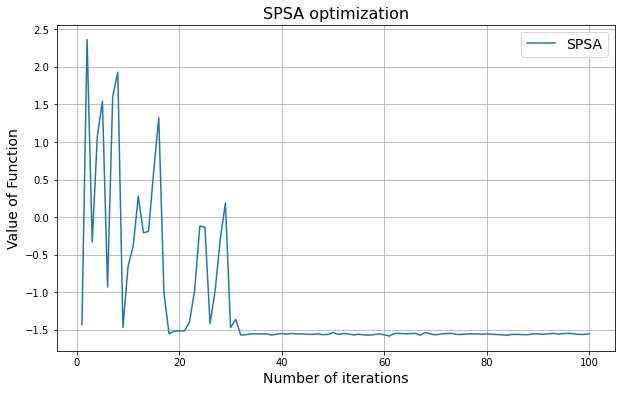

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(iterations1, values1, label="SPSA")
plt.xlabel("Number of iterations", fontsize=14)
plt.ylabel("Value of Function", fontsize=14)
plt.grid()

plt.title("SPSA optimization", fontsize=16)
plt.legend(fontsize=14)
plt.show()
plt.show()

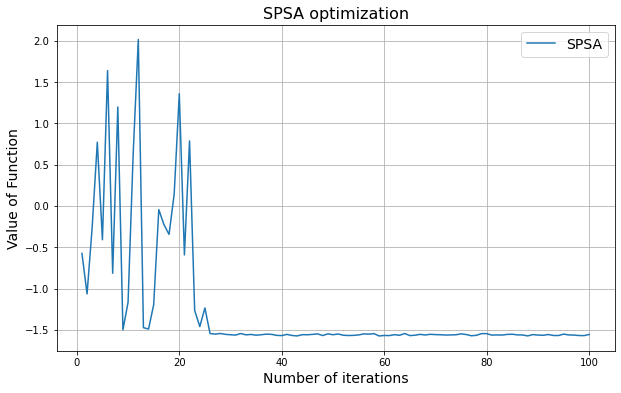

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(iterations2, values2, label="SPSA")
plt.xlabel("Number of iterations", fontsize=14)
plt.ylabel("Value of Function", fontsize=14)
plt.grid()

plt.title("SPSA optimization", fontsize=16)
plt.legend(fontsize=14)
plt.show()
plt.show()